In [1]:
import phippery
from phippery.normalize import rank_data_table, standardized_enrichment, cpm, size_factors
from phippery.utils import *
from phippery.tidy import tidy_ds
from phippery.modeling import gamma_poisson_model

import xarray as xr
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from plotnine import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import copy
from functools import reduce
from collections import defaultdict

import seaborn as sns
from statistics import *

# local alignment settings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist
matrix = matlist.blosum62
gap_open_penalty = -12
gap_extend_penalty = -3
    
# analysis settings
hits_filename = "hits_df.csv"    # list of shared hits after curation and thresholding
results_dir = "pep-align-plots"  # directory for output plots
ncut = 2                         # minimum number of samples a peptide must appear in as a hit
scorecut = 55                    # local alignment score threshold to accept peptide pairwise identical fraction


shared_hits_df = pd.read_csv(hits_filename)
unique_pep_df = shared_hits_df[["peptide_id","Prot_Start","Prot","Virus","Protein"]].drop_duplicates()
print("unique_pep_df.shape =", unique_pep_df.shape)

# create directory for plots, if it does not exist
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

unique_pep_df.shape = (456, 5)


/home/jared/miniconda3/envs/pan-cov-manuscript/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.


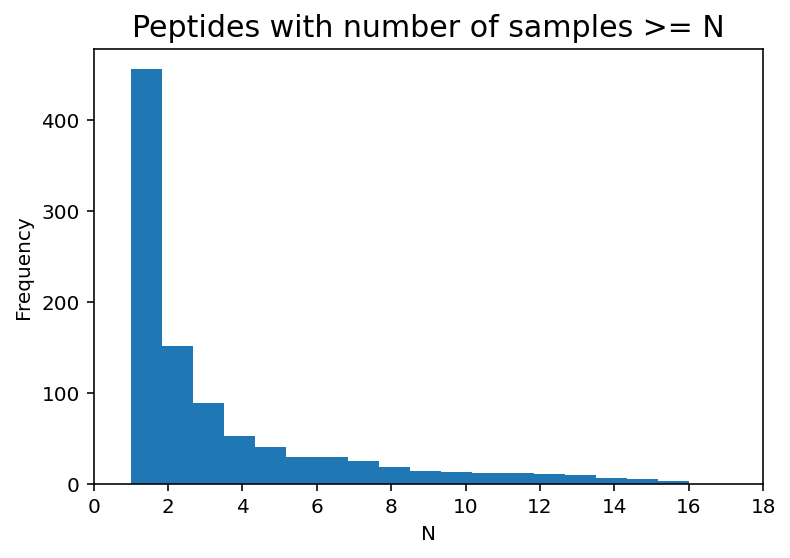

In [2]:
#-------------------------------------------------------------------------
# plot the number of peptides with at least N samples, as a function of N
#=========================================================================

nsamples=[]
for pepid in unique_pep_df['peptide_id']:
    n = len(shared_hits_df[shared_hits_df['peptide_id']==pepid]) 
    nsamples.append(n)
        
df = pd.DataFrame(nsamples)
ax0 = df.plot.hist(bins=18, cumulative=-1)
ax0.set_title("Peptides with number of samples >= N", fontsize=15)
ax0.get_legend().remove()
ax0.set_xlabel("N")
ax0.set_xlim(0,18)
plt.savefig(f"{results_dir}/hist_nsamples_anticumulative.png")

SARS mean score: 18.93223010244287 , max score: 230.0
MERS mean score: 17.43533215755438 , max score: 164.0
HKU1 mean score: 16.912074676302318 , max score: 174.0
OC43 mean score: 17.499208610319723 , max score: 128.0
229E mean score: 17.415931804820694 , max score: 167.0
NL63 mean score: 17.459125792459126 , max score: 176.0
HIV1 mean score: 16.395061728395063 , max score: 29.0
batSL mean score: 19.025191858525194 , max score: 239.0


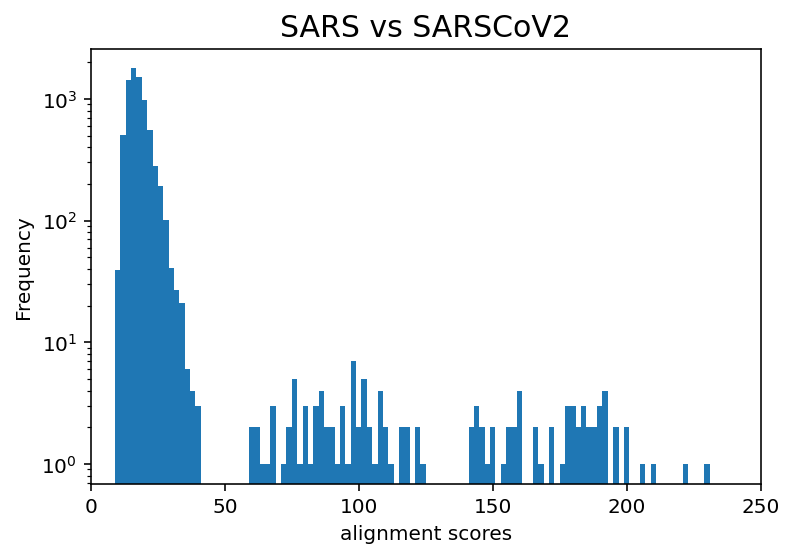

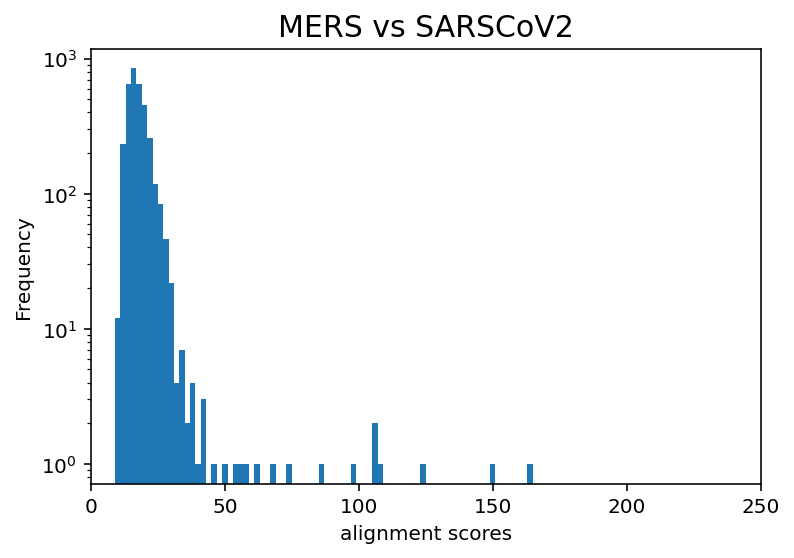

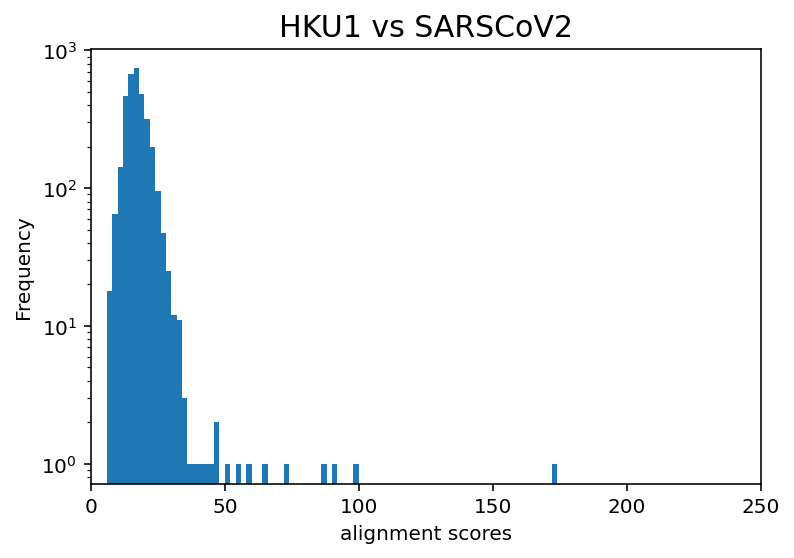

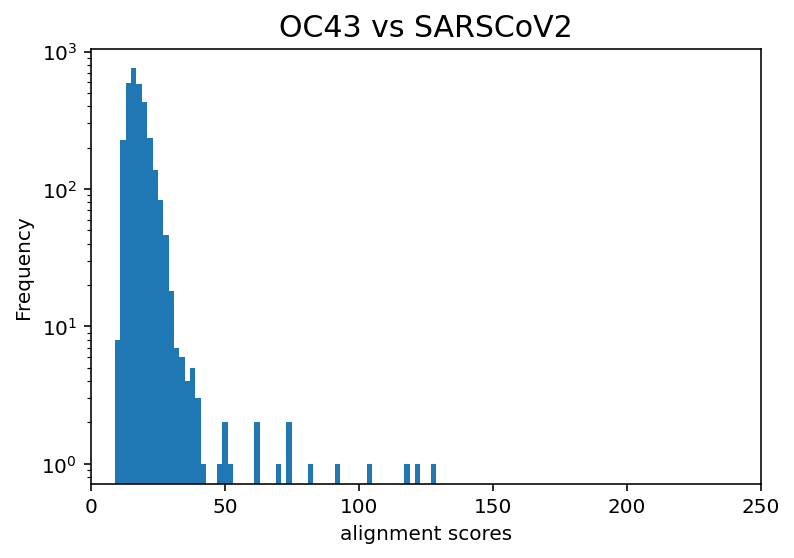

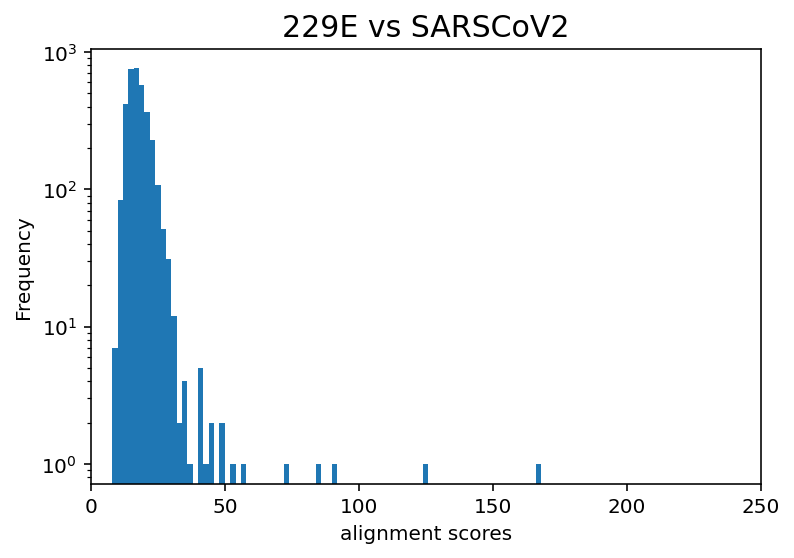

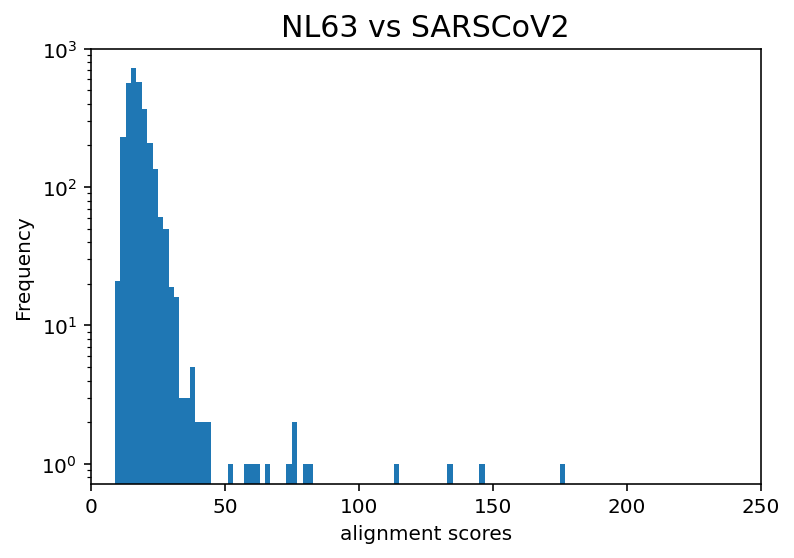

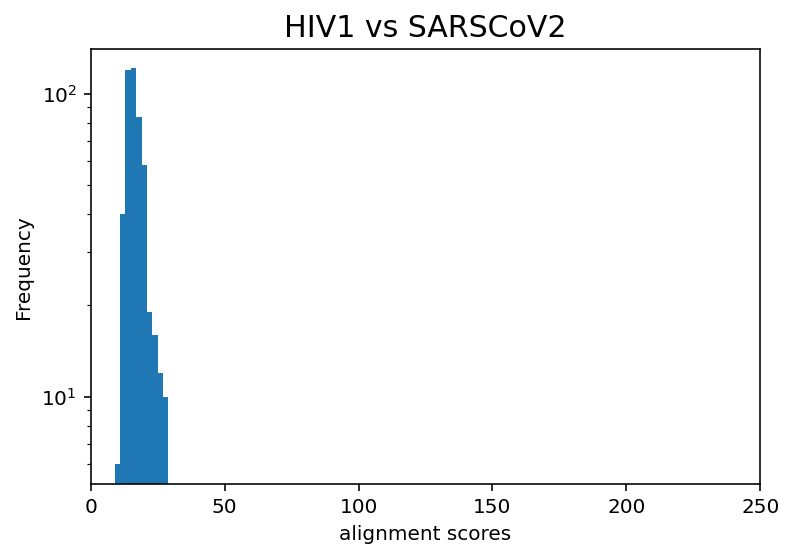

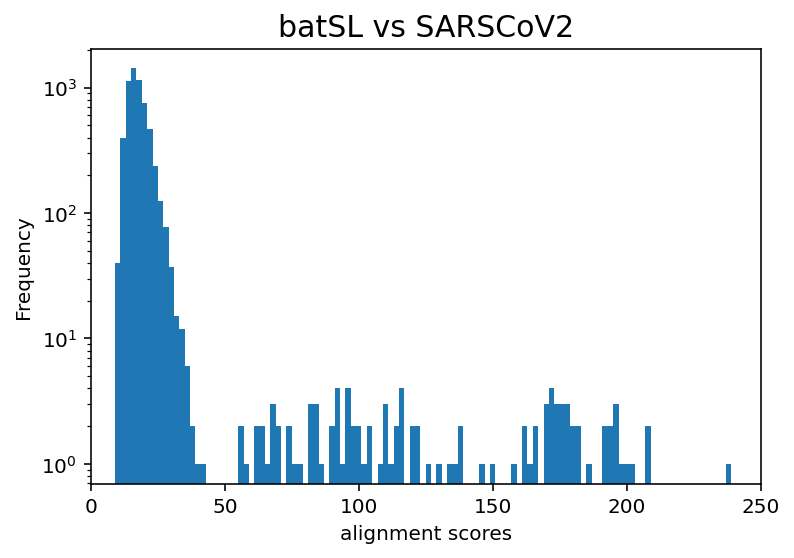

In [3]:
#--------------------------------------------------------------------------------------------------
# plot histograms of the distributions of local alignment scores between SARSCoV2 vs other viruses 
#==================================================================================================

scv2 = unique_pep_df[unique_pep_df["Virus"]=="SARSCoV2"]
prots_scv2 = pd.Series(data=scv2["Prot"].values, index=scv2["peptide_id"].values)

viruses = ['SARS', 'MERS', 'HKU1', 'OC43', '229E', 'NL63', 'HIV1', 'batSL']
for virus in viruses:
    virus_df = unique_pep_df[unique_pep_df["Virus"]==virus]
    prots_virus = pd.Series(data=virus_df["Prot"].values, index=virus_df["peptide_id"].values)
    scores=[]
    for prot1 in prots_scv2:
        for prot2 in prots_virus:          
            alignments = pairwise2.align.localds(prot1, prot2, matrix, gap_open_penalty, gap_extend_penalty)
            aln1, aln2, score, begin, end = alignments[0]
            scores.append(score)
            
    df = pd.DataFrame(scores)
    ax1 = df.plot.hist(bins=np.arange(min(scores), max(scores) + 2, 2))
    ax1.set_title(f"{virus} vs SARSCoV2", fontsize=15)
    ax1.get_legend().remove()
    ax1.set_xlabel("alignment scores")
    ax1.set_xlim(0,250)
    ax1.set_yscale("log")
    plt.savefig(f"{results_dir}/{virus}_SARSCoV2_scores_hist.png")
    print(virus, "mean score:", mean(scores), ", max score:", max(scores))

SARS : mean identical fraction: 0.014419982032368581
MERS : mean identical fraction: 0.0022592135943299424
HKU1 : mean identical fraction: 0.001538190669831287
OC43 : mean identical fraction: 0.002316663139014953
229E : mean identical fraction: 0.001010967124170994
NL63 : mean identical fraction: 0.0027034335229476217


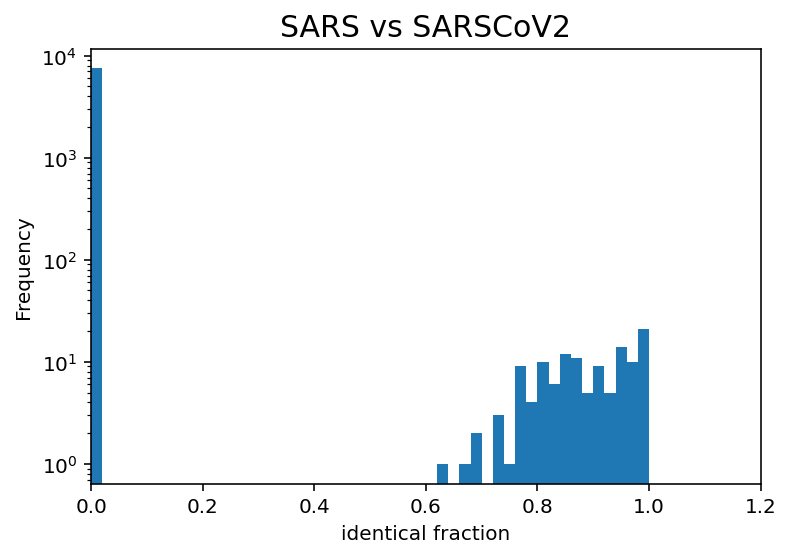

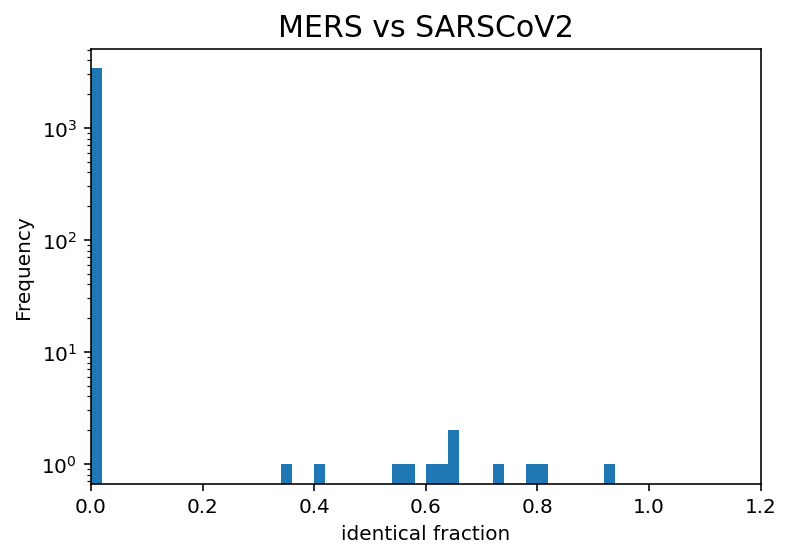

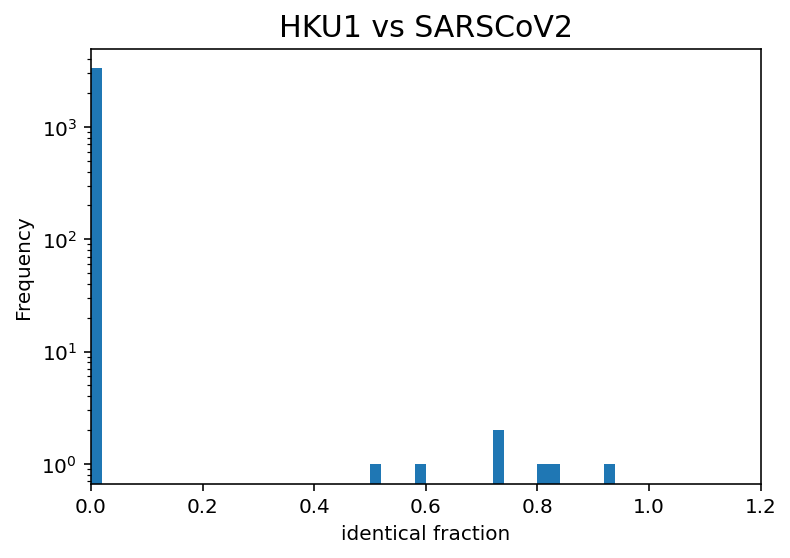

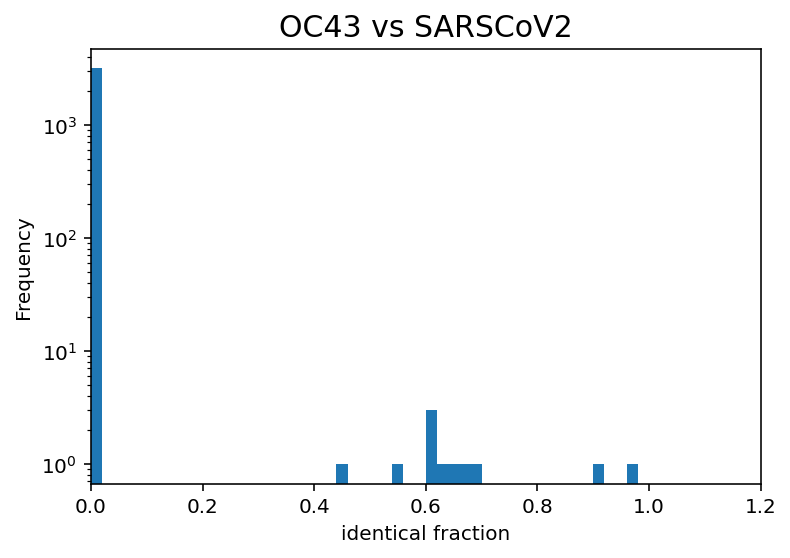

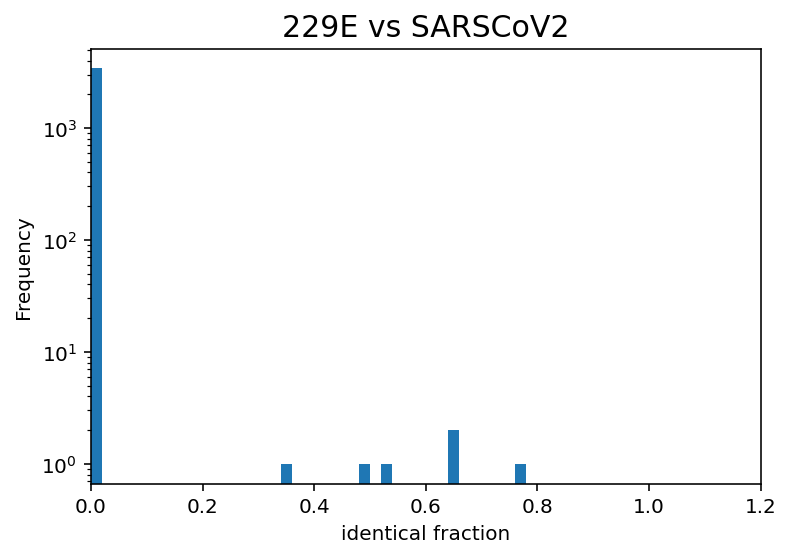

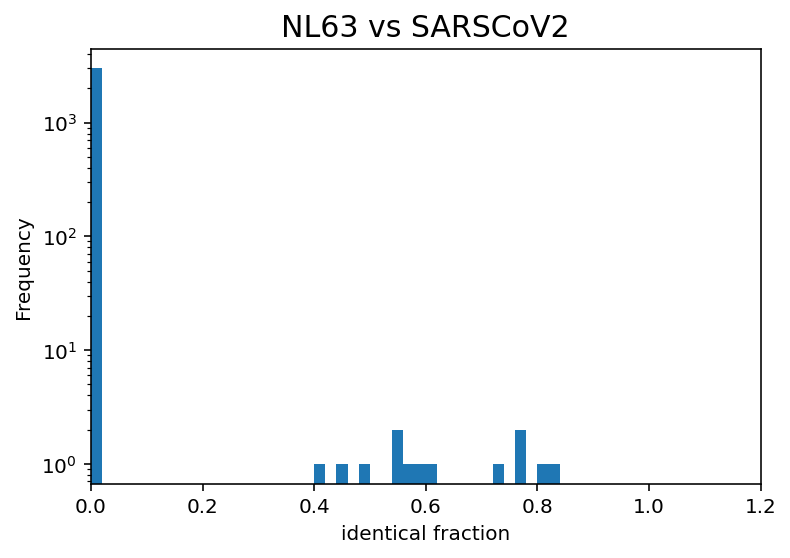

In [4]:
#-----------------------------------------------------------------------------------------------
# plot histograms of the distributions of identical fractions between SARSCoV2 vs other viruses
#   * identical fraction = (number of matches) / (length of locally aligned subsequence)
#   * pair alignment scores below {scorecut} are assigned identical fraction = 0
#===============================================================================================

scv2 = unique_pep_df[unique_pep_df["Virus"]=="SARSCoV2"]
prots_scv2 = pd.Series(data=scv2["Prot"].values, index=scv2["peptide_id"].values)

#viruses = ['SARS', 'MERS', 'HKU1', 'OC43', '229E', 'NL63', 'HIV1', 'batSL']
viruses = ['SARS', 'MERS', 'HKU1', 'OC43', '229E', 'NL63']
for virus in viruses:
    virus_df = unique_pep_df[unique_pep_df["Virus"]==virus]
    prots_virus = pd.Series(data=virus_df["Prot"].values, index=virus_df["peptide_id"].values)
    frac_id=[]
    for prot1 in prots_scv2:
        for prot2 in prots_virus:
            alignments = pairwise2.align.localds(prot1, prot2, matrix, gap_open_penalty, gap_extend_penalty)
            aln1, aln2, score, begin, end = alignments[0]
            matches = [aln1[i]==aln2[i] for i in range(begin, end)]
            if score > scorecut:
                frac_id.append( sum(matches)/(end - begin) )
            else:
                frac_id.append(0)
            
    df = pd.DataFrame(frac_id)
    ax2 = df.plot.hist(bins=np.arange(min(frac_id), max(frac_id) + 0.02, 0.02))
    ax2.set_title(f"{virus} vs SARSCoV2", fontsize=15)
    ax2.get_legend().remove()
    ax2.set_xlabel("identical fraction")
    ax2.set_xlim(0,1.2)
    ax2.set_yscale("log")
    plt.savefig(f"{results_dir}/{virus}_SARSCoV2_frac_id_hist.png")
    print(virus, ": mean identical fraction:", mean(frac_id))

In [5]:
#-------------------------------------------------------------------------------------------
# compute pairwise identical fractions of SARSCoV2 vs other viruses, for specified protein
#   * peptides must be hits in at least {ncut} samples
#   * pair alignment scores below {scorecut} are assigned identical fraction = 0
#   * figure width adjusted via {fig_width}
#   * x-position for legend of HCoV labels adjusted via {vir_text_x}
#===========================================================================================

def pair_align_analysis(my_protein, fig_width=10, vir_text_x=-1):
    scv2 = unique_pep_df[unique_pep_df["Virus"]=="SARSCoV2"]
    scv2 = scv2[scv2["Protein"]==my_protein]

    viruses = ['OC43', 'NL63', 'HKU1', '229E', 'MERS', 'SARS']
    virus_colors = ['dodgerblue', 'lightseagreen', 'yellowgreen', 'brown', 'forestgreen', 'mediumblue']
    
    # apply number of samples cut on SARS-CoV-2 peptides
    prots_scv2 = pd.Series(data=scv2["Prot"].values, index=scv2["peptide_id"].values)
    high_n_scv2 = {}
    for pepid, protstart in scv2.loc[:, ["peptide_id", "Prot_Start"]].values:
        n = len(shared_hits_df[shared_hits_df['peptide_id']==pepid])
        if n >= ncut:
            high_n_scv2.update({pepid : protstart})

    # sort selected peptides by protein start position
    sorted_high_n_scv2 = sorted(high_n_scv2.items(), key=lambda x : x[1])
    high_n_protstart_scv2=[]
    for pepid, protstart in sorted_high_n_scv2:
        high_n_protstart_scv2.append(protstart)

    # apply number of samples cut on other HCoV peptides
    sorted_high_n_vir=[]
    for virus in viruses:
        high_n_tmp={}
        virus_df = unique_pep_df[unique_pep_df["Virus"]==virus]
        if my_protein in ['spike', 'nucleocapsid', 'replicase_polyprotein_1ab']:
            virus_df = virus_df[virus_df["Protein"]==my_protein]
        for pepid, protstart in virus_df.loc[:, ["peptide_id", "Prot_Start"]].values:
            n = len(shared_hits_df[shared_hits_df['peptide_id']==pepid])
            if n >= ncut:
                high_n_tmp.update({pepid : protstart})
        # sort selected peptides by protein start position
        sorted_high_n_vir = sorted_high_n_vir + sorted(high_n_tmp.items(), key=lambda x : x[1])
    
    high_n_protstart_vir=[]
    for pepid, protstart in sorted_high_n_vir:
        high_n_protstart_vir.append(protstart)

    # construct matrix of identical fractions
    frac_mat=[]
    for vir_pepid, vir_protstart in sorted_high_n_vir:
        vir_prot = str(unique_pep_df[unique_pep_df["peptide_id"]==vir_pepid]["Prot"].values[0])
        vir_frac=[]
        for scv2_pepid, scv2_protstart in sorted_high_n_scv2:
            scv2_prot = str(unique_pep_df[unique_pep_df["peptide_id"]==scv2_pepid]["Prot"].values[0])
            alignments = pairwise2.align.localds(vir_prot, scv2_prot, matrix, gap_open_penalty, gap_extend_penalty)
            aln1, aln2, score, begin, end = alignments[0]
            matches = [aln1[i]==aln2[i] for i in range(begin, end)]
            if score > scorecut:
                vir_frac.append( sum(matches)/(end - begin)*100. )
                print(my_protein)
                print("{0:10} {1:6} {2:6}  {3}  {4}  {5}".format("SARSCoV2", scv2_pepid, scv2_protstart,
                                                                 scv2_prot, aln2, aln2[begin:end]))
                vir_name = str(unique_pep_df[unique_pep_df["peptide_id"]==vir_pepid]["Virus"].values[0])
                print("{0:10} {1:6} {2:6}  {3}  {4}  {5}".format(vir_name, vir_pepid, vir_protstart,
                                                                 vir_prot, aln1, aln1[begin:end]))
                print("begin =", begin, ", end =", end)
                print("score =", score)
                print("identical fraction =", vir_frac[-1], "%")
                print("\n")
            else:
                vir_frac.append(0)
        frac_mat.append(vir_frac)

    frac_df = pd.DataFrame(data=frac_mat, index=high_n_protstart_vir, columns=high_n_protstart_scv2)
    frac_df.shape
    

    tick_colors = {}
    for virus, color in zip(viruses, virus_colors):
        df = unique_pep_df[unique_pep_df["Virus"]==virus]
        for pepid in df["peptide_id"]:
            tick_colors.update({pepid : color})

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(fig_width, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_ax = sns.heatmap(frac_df, cmap=cmap, center=0, square=True, linewidths=0.1, 
                         cbar_kws={"shrink": .8, "label": "local alignment identical fraction [%]"})
    sns_ax.figure.axes[-1].yaxis.label.set_size(20)
    sns_ax.collections[0].colorbar.ax.tick_params(labelsize=14)

    if my_protein in ['spike', 'nucleocapsid', 'replicase_polyprotein_1ab']:
        ax.set_title(my_protein, fontsize=18)
    else:
        ax.set_title(f"Peptide Pairwise Identical Fraction\n $\geq${ncut} samples", fontsize=18)
    ax.tick_params(axis="x", labelsize=12, rotation=90)
    ax.tick_params(axis="y", labelsize=12, rotation=0)
    ax.set_xlabel('\nSARS-CoV-2 peptide position', fontsize=18, verticalalignment='top')
    ax.set_ylabel('endemic CoV peptide position\n', fontsize=18, verticalalignment='bottom')

    icol=0
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_color(tick_colors[int(sorted_high_n_vir[icol][0])])
        icol = icol + 1

    yoffset=0
    for textstr, fontcolor in zip(viruses, virus_colors):
        ax.text(vir_text_x, 0.98-yoffset, textstr, transform=ax.transAxes, fontsize=18, color=fontcolor,
               horizontalalignment='left', verticalalignment='top')
        yoffset = yoffset+0.035

    f.savefig(f"{results_dir}/fracmap_nsamp{ncut}_{my_protein}.png")

ValueError: zero-size array to reduction operation fmin which has no identity

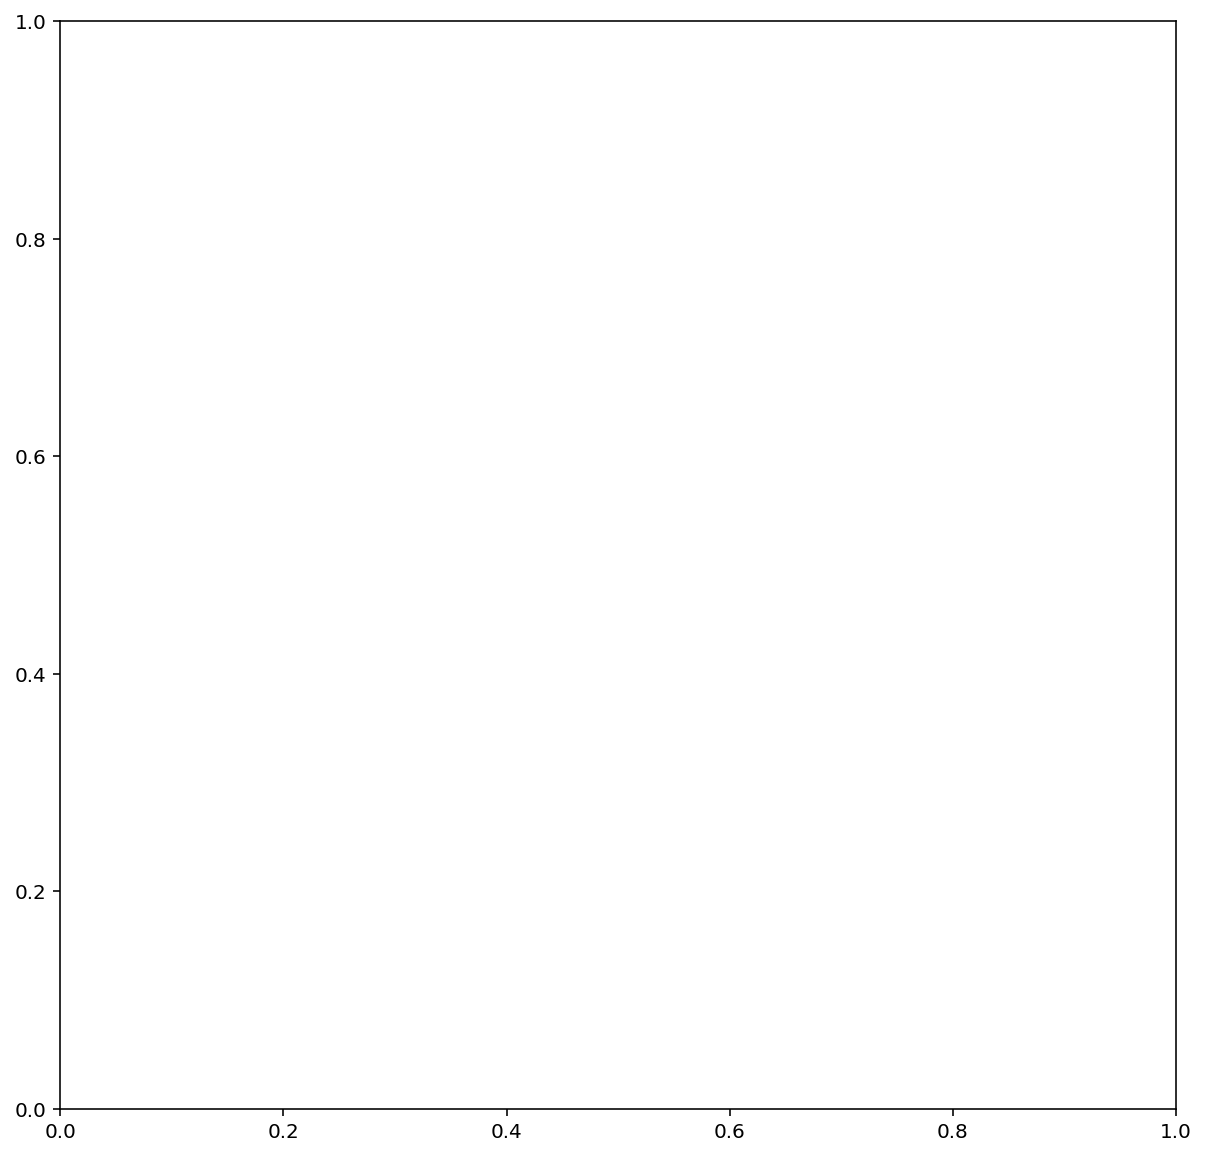

In [6]:
pair_align_analysis('spike', 10, -0.4)

In [ ]:
pair_align_analysis('nucleocapsid', 7, -0.7)

In [ ]:
pair_align_analysis('replicase_polyprotein_1ab', 6, -1.5)